# Image Classification Using Transfer Learning

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, we might want to include an image classifier in a smart phone app. To do this, we'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, we'll train an image classifier to recognize different species of flowers. We can imagine using something like this in a phone app that tells us the name of the flower our camera is looking at. In practice we'd train this classifier, then export it for use in our application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, we can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use our trained model to perform inference on flower images.


## Install Datasets and Upgrade TensorFlow

To ensure we can download the latest version of the `oxford_flowers102` dataset, let's first install both `tensorflow-datasets` and `tfds-nightly`.
* `tensorflow-datasets` is the stable version that is released on a cadence of every few months
* `tfds-nightly` is released every day and has the latest version of the datasets

We'll also upgrade TensorFlow to ensure we have a version that is compatible with the latest version of the dataset.

In [ ]:


%pip --no-cache-dir install tfds-nightly --user
%pip --no-cache-dir install --upgrade tensorflow --user
%pip --no-cache-dir install --upgrade tensorflow-datasets --user


After the above installations have finished **we need to be sure to restart the kernel**. we can do this by going to **Kernel > Restart**.

In [1]:
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

# Ignore some warnings that are not relevant (you can remove this if you prefer)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# TODO: Make all other necessary imports.
import time
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Some other recommended settings:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
tfds.disable_progress_bar()

## Load the Dataset

Here we'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  we'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but we'll still need to normalize and resize the images to the appropriate size.

In [5]:
# TODO: Load the dataset with TensorFlow Datasets. Hint: use tfds.load()

dataset, dataset_info= tfds.load('oxford_flowers102:2.1.1', as_supervised=True, with_info=True)

# TODO: Create a training set, a validation set and a test set.
training, testing, validation = dataset['train'], dataset['test'], dataset['validation']


## Explore the Dataset

In [6]:
# TODO: Get the number of examples in each set from the dataset info.
num_classes= dataset_info.features['label'].num_classes
train_examples = dataset_info.splits['train'].num_examples
test_examples = dataset_info.splits['test'].num_examples
validation_examples = dataset_info.splits['validation'].num_examples
print('The Dataset has a total of:')

print('\u2022 {:,} train images'.format(train_examples))
print('\u2022 {:,} test images'.format(test_examples))
print('\u2022 {:,} validation images'.format(validation_examples))
# TODO: Get the number of classes in the dataset from the dataset info.
print('\u2022 {:,} classes'.format(num_classes))

The Dataset has a total of:
• 1,020 train images
• 6,149 test images
• 1,020 validation images
• 102 classes


In [7]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for i, (image, label) in enumerate(training.take(3)):
    image = image.numpy()
    label = label.numpy()
    print('\u2022 Image {:} has shape of {:} and label of {:} '.format(i, str(image.shape), label))

• Image 0 has shape of (500, 667, 3) and label of 72 
• Image 1 has shape of (500, 666, 3) and label of 84 
• Image 2 has shape of (670, 500, 3) and label of 70 


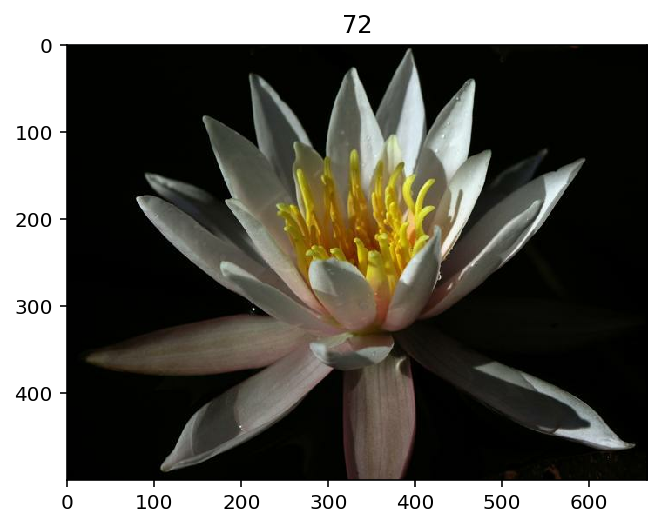

In [8]:
# TODO: Plot 1 image from the training set. 
for image, label in training.take(1):
    image = image.numpy()
    label = label.numpy()

plt.imshow(image)
plt.title(label)
plt.show()
# Set the title of the plot to the corresponding image label. 

### Label Mapping

We'll also need to load in a mapping from label to category name. We can find this in the file `label_map.json`. It's a JSON object which we can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give us a dictionary mapping the integer coded labels to the actual names of the flowers.

In [11]:
class_names = dataset_info.features['label'].names
class_names

['pink primrose',
 'hard-leaved pocket orchid',
 'canterbury bells',
 'sweet pea',
 'english marigold',
 'tiger lily',
 'moon orchid',
 'bird of paradise',
 'monkshood',
 'globe thistle',
 'snapdragon',
 "colt's foot",
 'king protea',
 'spear thistle',
 'yellow iris',
 'globe-flower',
 'purple coneflower',
 'peruvian lily',
 'balloon flower',
 'giant white arum lily',
 'fire lily',
 'pincushion flower',
 'fritillary',
 'red ginger',
 'grape hyacinth',
 'corn poppy',
 'prince of wales feathers',
 'stemless gentian',
 'artichoke',
 'sweet william',
 'carnation',
 'garden phlox',
 'love in the mist',
 'mexican aster',
 'alpine sea holly',
 'ruby-lipped cattleya',
 'cape flower',
 'great masterwort',
 'siam tulip',
 'lenten rose',
 'barbeton daisy',
 'daffodil',
 'sword lily',
 'poinsettia',
 'bolero deep blue',
 'wallflower',
 'marigold',
 'buttercup',
 'oxeye daisy',
 'common dandelion',
 'petunia',
 'wild pansy',
 'primula',
 'sunflower',
 'pelargonium',
 'bishop of llandaff',
 'gaura',

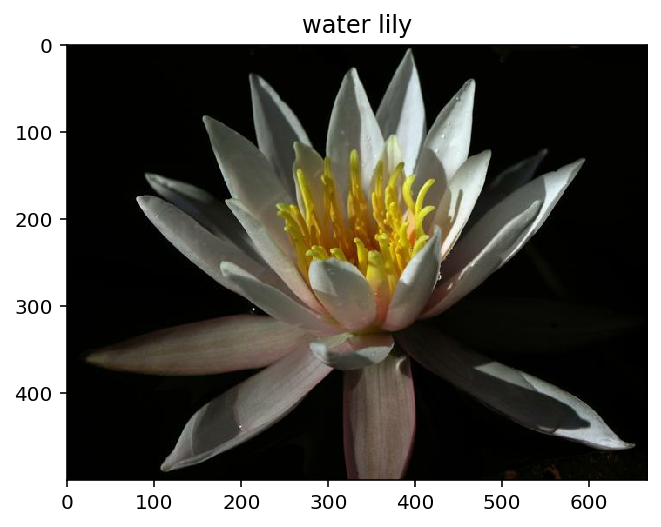

In [12]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
for image, label in training.take(1):
    image = image.numpy()
    label = label.numpy()

plt.imshow(image)
plt.title(class_names[label])
plt.show()


## Create Pipeline
Our pipeline will be fairly simple. we will cast the pixel values type from integer to float, then resize the images to the model's input size, and finally, normalize the pixel values using MinMax, essentially. 

In [13]:
# TODO: Create a pipeline for each set.

batch_size = 32
image_size = 224

num_training_examples = test_examples
print(num_training_examples)
print(testing)
@tf.autograph.experimental.do_not_convert
def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label


training_batches = testing.shuffle(num_training_examples//8).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation.map(format_image).batch(batch_size).prefetch(1)
testing_batches = training.map(format_image).batch(batch_size).prefetch(1)


6149
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. We should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

 Things we'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save our trained model as a Keras model. 


When training we need to make sure that we're updating only the weights of the feed-forward network. We should be able to get the validation accuracy above 70% if you build everything right.


In [14]:
# TODO: Build and train your network.

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))

feature_extractor.trainable = False

#initializer = tf.keras.initializers.GlorotUniform(seed = 42)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
print('Is there a GPU Available:', tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Is there a GPU Available: False


In [24]:
import signal

from contextlib import contextmanager

import requests


DELAY = INTERVAL = 4 * 60  # interval time in seconds
MIN_DELAY = MIN_INTERVAL = 2 * 60
KEEPALIVE_URL = "https://nebula.udacity.com/api/v1/remote/keep-alive"
TOKEN_URL = "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token"
TOKEN_HEADERS = {"Metadata-Flavor":"Google"}


def _request_handler(headers):
    def _handler(signum, frame):
        requests.request("POST", KEEPALIVE_URL, headers=headers)
    return _handler


@contextmanager
def active_session(delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import active session

    with active_session():
        # do long-running work here
    """
    token = requests.request("GET", TOKEN_URL, headers=TOKEN_HEADERS).text
    headers = {'Authorization': "STAR " + token}
    delay = max(delay, MIN_DELAY)
    interval = max(interval, MIN_INTERVAL)
    original_handler = signal.getsignal(signal.SIGALRM)
    try:
        signal.signal(signal.SIGALRM, _request_handler(headers))
        signal.setitimer(signal.ITIMER_REAL, delay, interval)
        yield
    finally:
        signal.signal(signal.SIGALRM, original_handler)
        signal.setitimer(signal.ITIMER_REAL, 0)


def keep_awake(iterable, delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import keep_awake

    for i in keep_awake(range(5)):
        # do iteration with lots of work here
    """
    with active_session(delay, interval): yield from iterable

In [25]:
model.compile(optimizer = "adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 15

from keras.callbacks import CSVLogger

csv_logger = CSVLogger("model_history_log.csv", append=True)
save_best = tf.keras.callbacks.ModelCheckpoint('./best_model.h5',
                                              monitor='val_loss',
                                              save_best_only = True)


with active_session():
    history = model.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                   callbacks=[csv_logger,save_best])

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
193/193 [==============================] - ETA: 0s - loss: 1.9501 - accuracy: 0.5986WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f752684eb00> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
193/193 [==============================] - 150s 749ms/step - loss: 1.9501 - accuracy: 0.5986 - val_loss: 1.0177 - val_accuracy: 0.7765
Epoch 2/15
193/193 [==============================] - 145s 747ms/step - loss: 0.5414 - accuracy: 0.9047 - val_loss: 0.6419 - val_accuracy: 0.8598
Epoch 3/15
193/193 [==============================] - 142s 734ms/step - loss: 0.3116 - accuracy: 0.9494 - val_loss: 0.5190 - val_accuracy: 0.8794
Epoch 4/15
193/193 [==============================] - 147s 758ms/step - loss: 0.2073 - accuracy: 0.9694 - val_loss: 0.4678 - val_accuracy: 0.8824
Epoch 5/15
193/193 [==============================] - 144s 743ms/step - loss: 0.1472 - accuracy: 0.9821 - val_loss: 

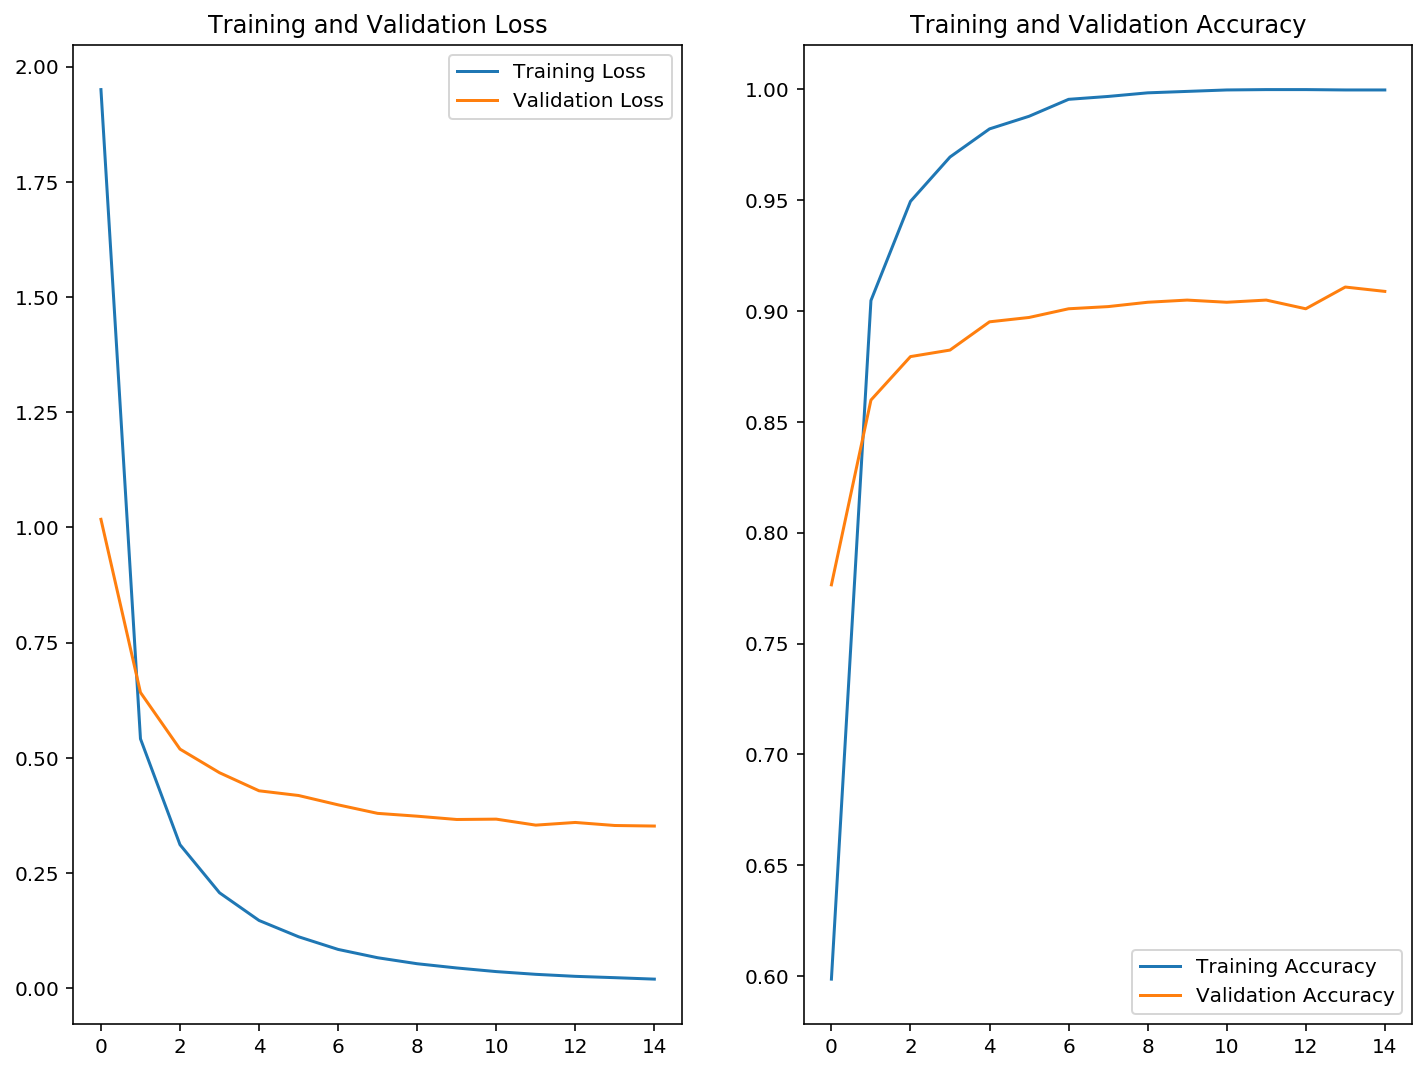

In [26]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(figsize=(12,9), ncols=2)
ax1.plot(history.history['loss'], label = 'Training Loss')
ax1.plot(history.history['val_loss'], label = 'Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax2.plot(history.history['accuracy'], label = 'Training Accuracy')
ax2.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
plt.show()


## Testing our Network

It's good practice to test our trained network on test data, images the network has never seen either in training or validation. This will give us a good estimate for the model's performance on completely new images. we should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [27]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
loss, accuracy = model.evaluate(testing_batches)
print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

32/32 [==============================] - 21s 637ms/step - loss: 0.4174 - accuracy: 0.8794

Loss on the TEST Set: 0.417
Accuracy on the TEST Set: 87.941%


## Save the Model

Now that our network is trained, next step is to save the model so we can load it later for making inference. In the cell below we will save our model as a Keras model (*i.e.* save it as an HDF5 file).

In [28]:
# TODO: Save your trained model as a Keras model.
model.save('saved_model/my_model')


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


## Load the Keras Model

Here we load the Keras model we saved above.

In [29]:
# TODO: Load the Keras model
loaded_model = tf.keras.models.load_model('saved_model/my_model',custom_objects = {'KerasLayer':hub.KerasLayer})
loaded_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification

Now we'll write a function that uses our trained network for inference. We write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Our `predict` function will use `PIL` to load the image from the given `image_path`. we can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. We can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by our model. we wrote a separate function called `process_image` that performs the pre-processing. we can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, we should convert our image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, we'll also need to normalize the pixel values. 

Finally, convert our image back to a NumPy array using the `.numpy()` method.

In [30]:
# TODO: Create the process_image function
# TODO: Create the process_image function
@tf.autograph.experimental.do_not_convert
def process_image(image):
    image = tf.convert_to_tensor(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image /= 255
    image = image.numpy()
    image = image.reshape((224, 224, 3))
    image = image.astype('float32')
    return image

To check our `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by our `process_image` function. If our `process_image` function works, the plotted image should be the correct size. 

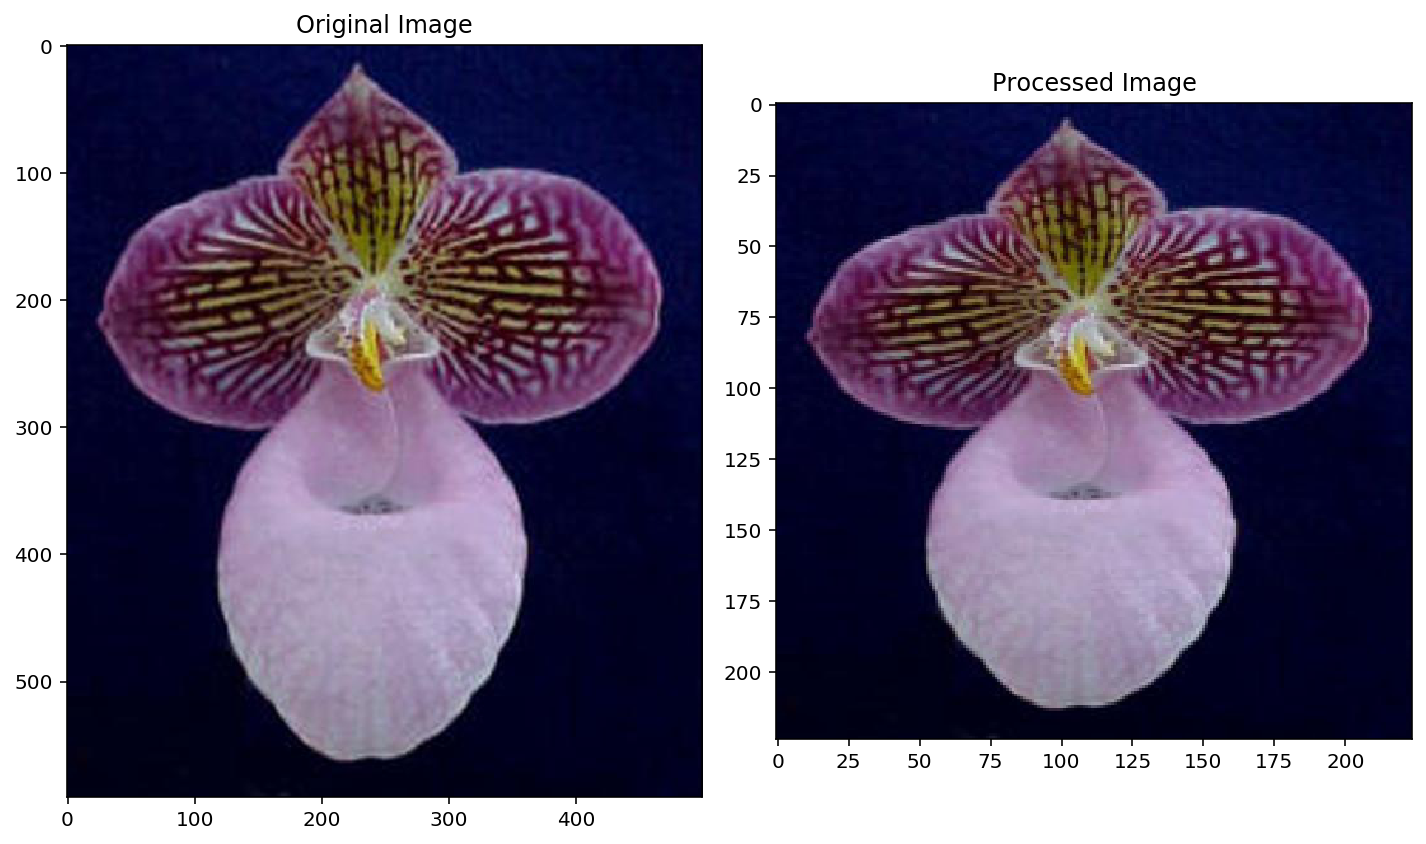

In [31]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once we can get images in the correct format, it's time to write the `predict` function for making inference with our model.

### Inference

We need tp remember that the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Our `predict` function should use `PIL` to load the image from the given `image_path`. We can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. We can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Something to note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We will use the `np.expand_dims()` function to add the extra dimension. 

In [36]:
# TODO: Create the predict function
@tf.autograph.experimental.do_not_convert
def predict(image_path, model, k_classes):
    img = Image.open(image_path)
    img = np.asarray(img)
    img = process_image(img)
    img = tf.expand_dims(img, axis = 0)
    probs = model.predict(img)
    values, indices = tf.nn.top_k(probs,k = k_classes)
    probs = list(values.numpy()[0])
    classes = list(indices.numpy()[0])
    return classes, probs


# Sanity Check

It's always good to check the predictions made by our model to make sure they are correct. To check our predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below we used `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by our model. We plot the probabilities as a bar graph. 

['./test_images/orange_dahlia.jpg', './test_images/wild_pansy.jpg', './test_images/hard-leaved_pocket_orchid.jpg', './test_images/cautleya_spicata.jpg']
1/1 [==============================] - 0s 45ms/step
[0.9901142, 0.00311968, 0.0024334248, 0.0017630706, 0.0007156034] [58, 4, 40, 65, 82]


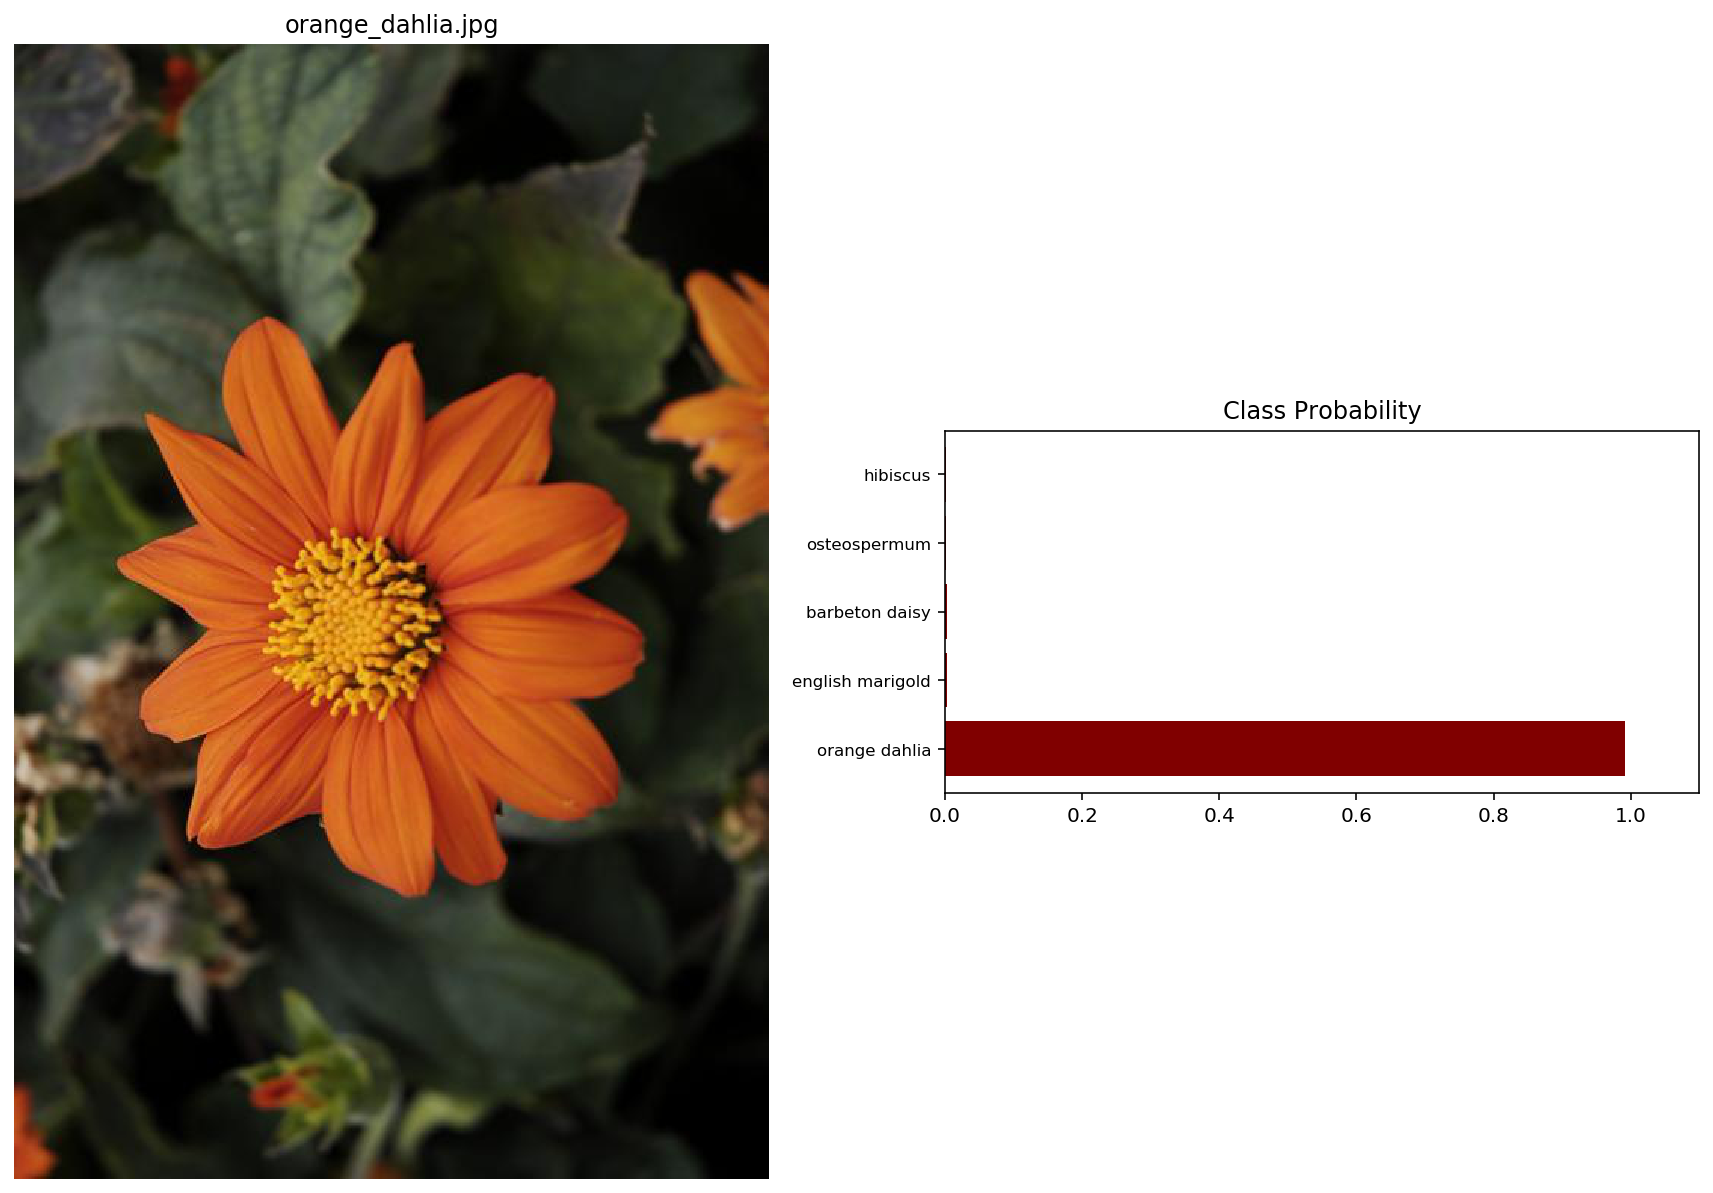

1/1 [==============================] - 0s 47ms/step
[0.9999242, 1.8207156e-05, 9.460714e-06, 6.4154347e-06, 5.205768e-06] [51, 52, 18, 85, 33]


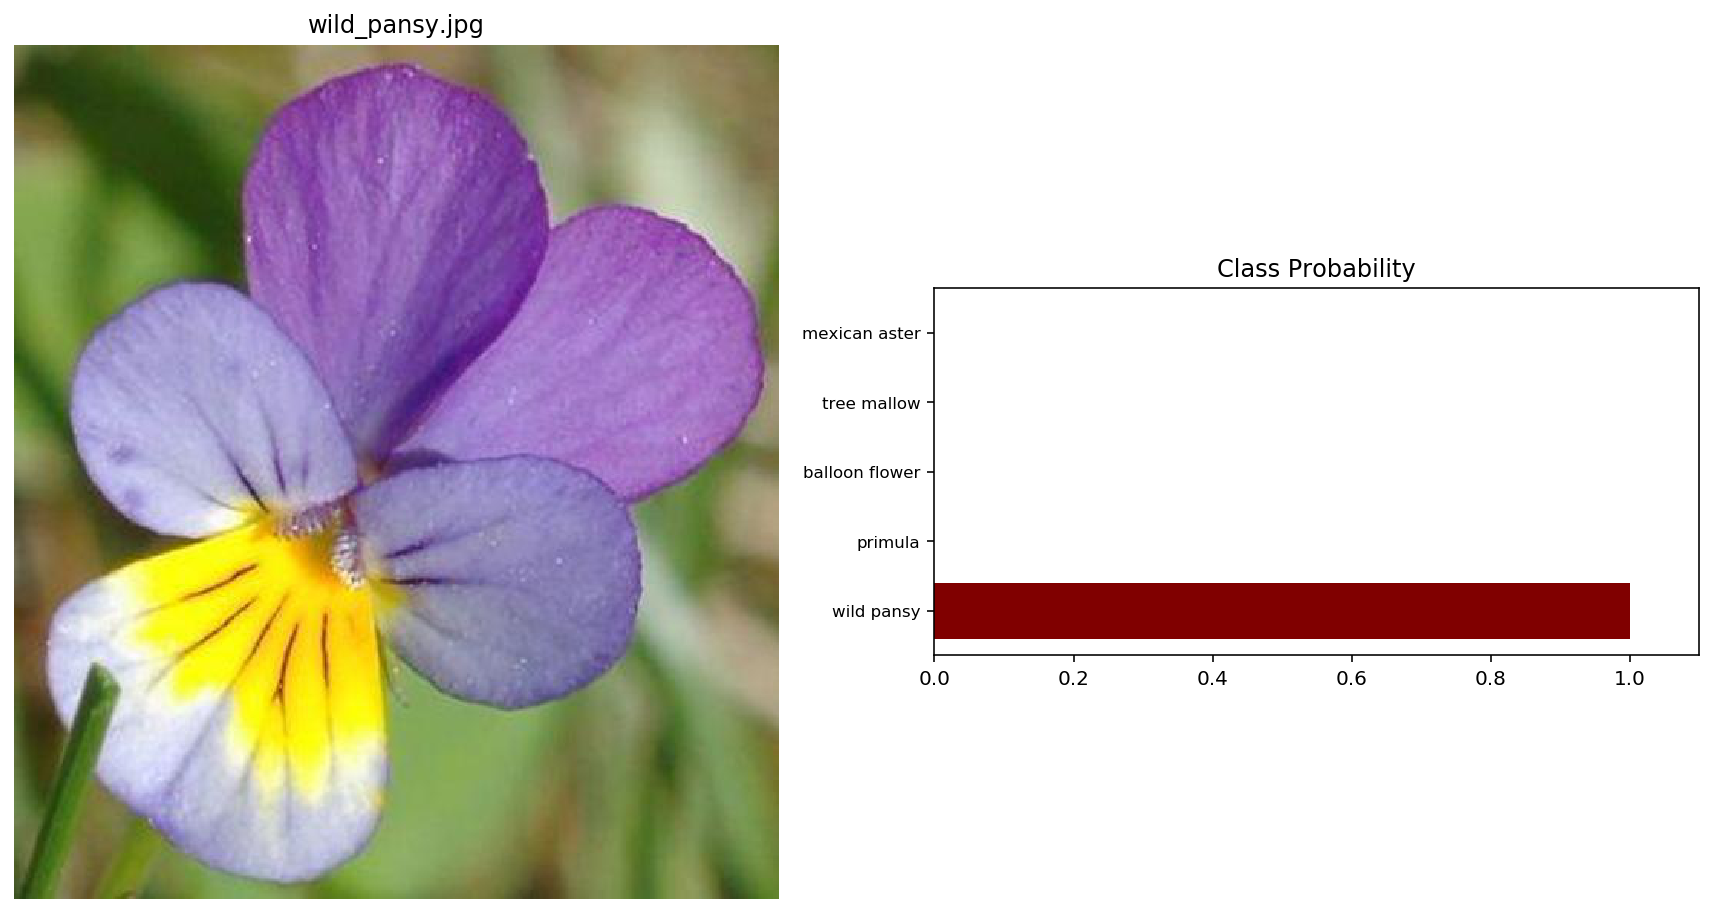

1/1 [==============================] - 0s 45ms/step
[0.99976355, 0.00018564722, 1.6534252e-05, 7.753721e-06, 7.514741e-06] [1, 17, 76, 93, 6]


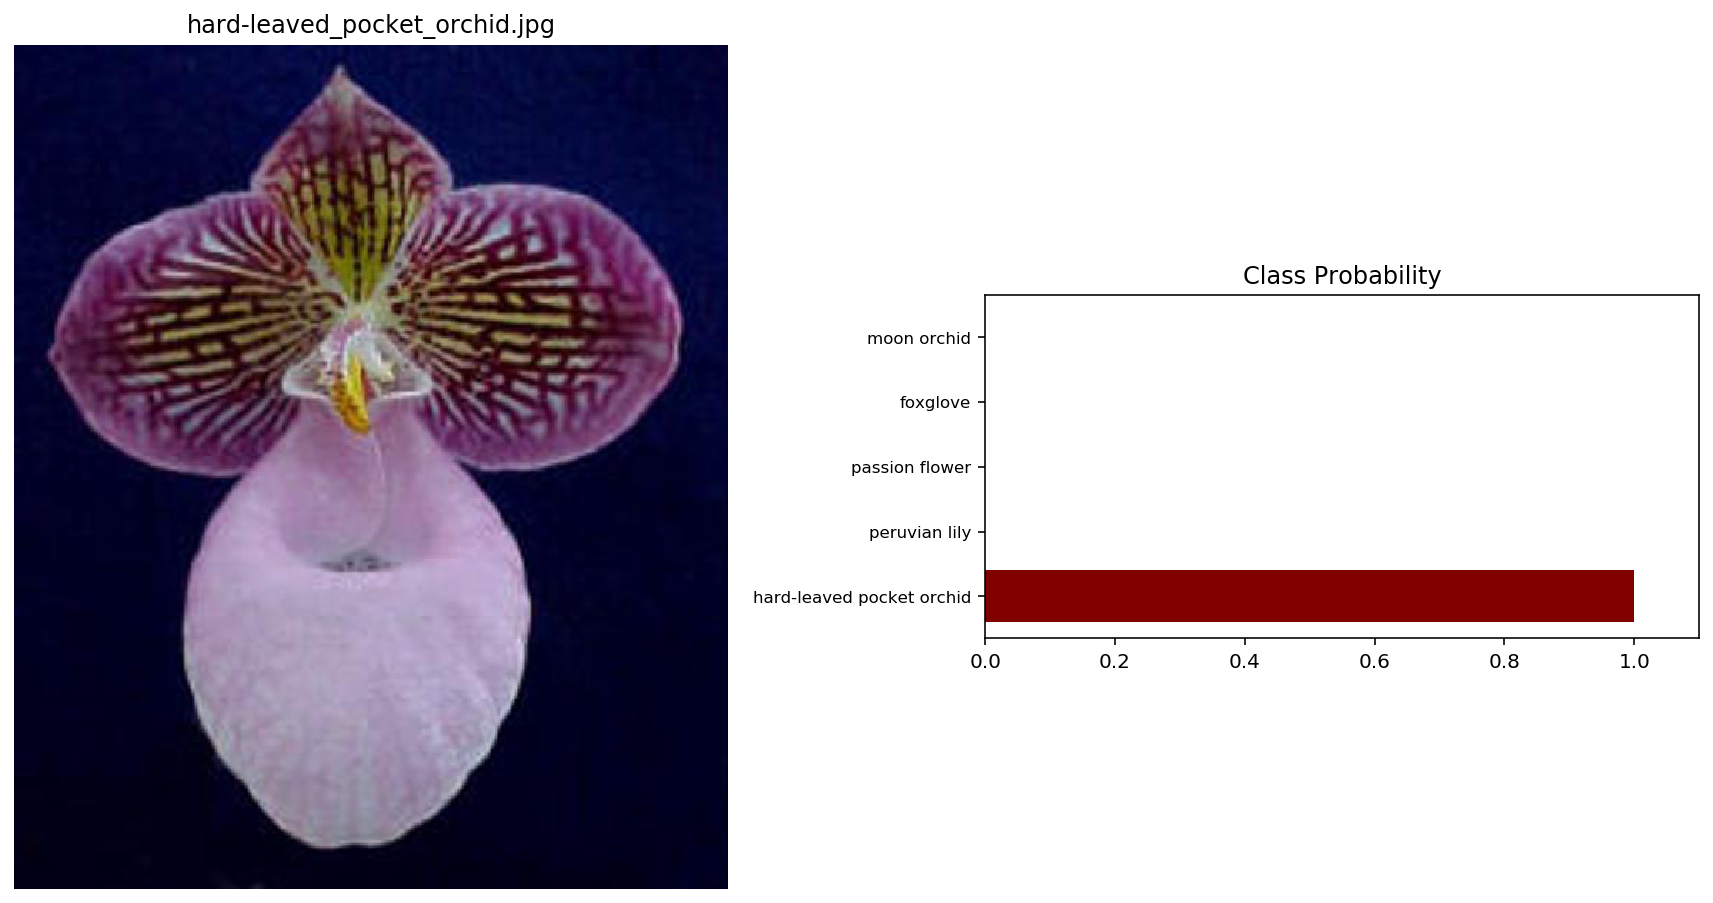

1/1 [==============================] - 0s 45ms/step
[0.99822885, 0.00028676438, 0.00019084635, 0.00018190933, 0.00013433058] [60, 93, 23, 83, 42]


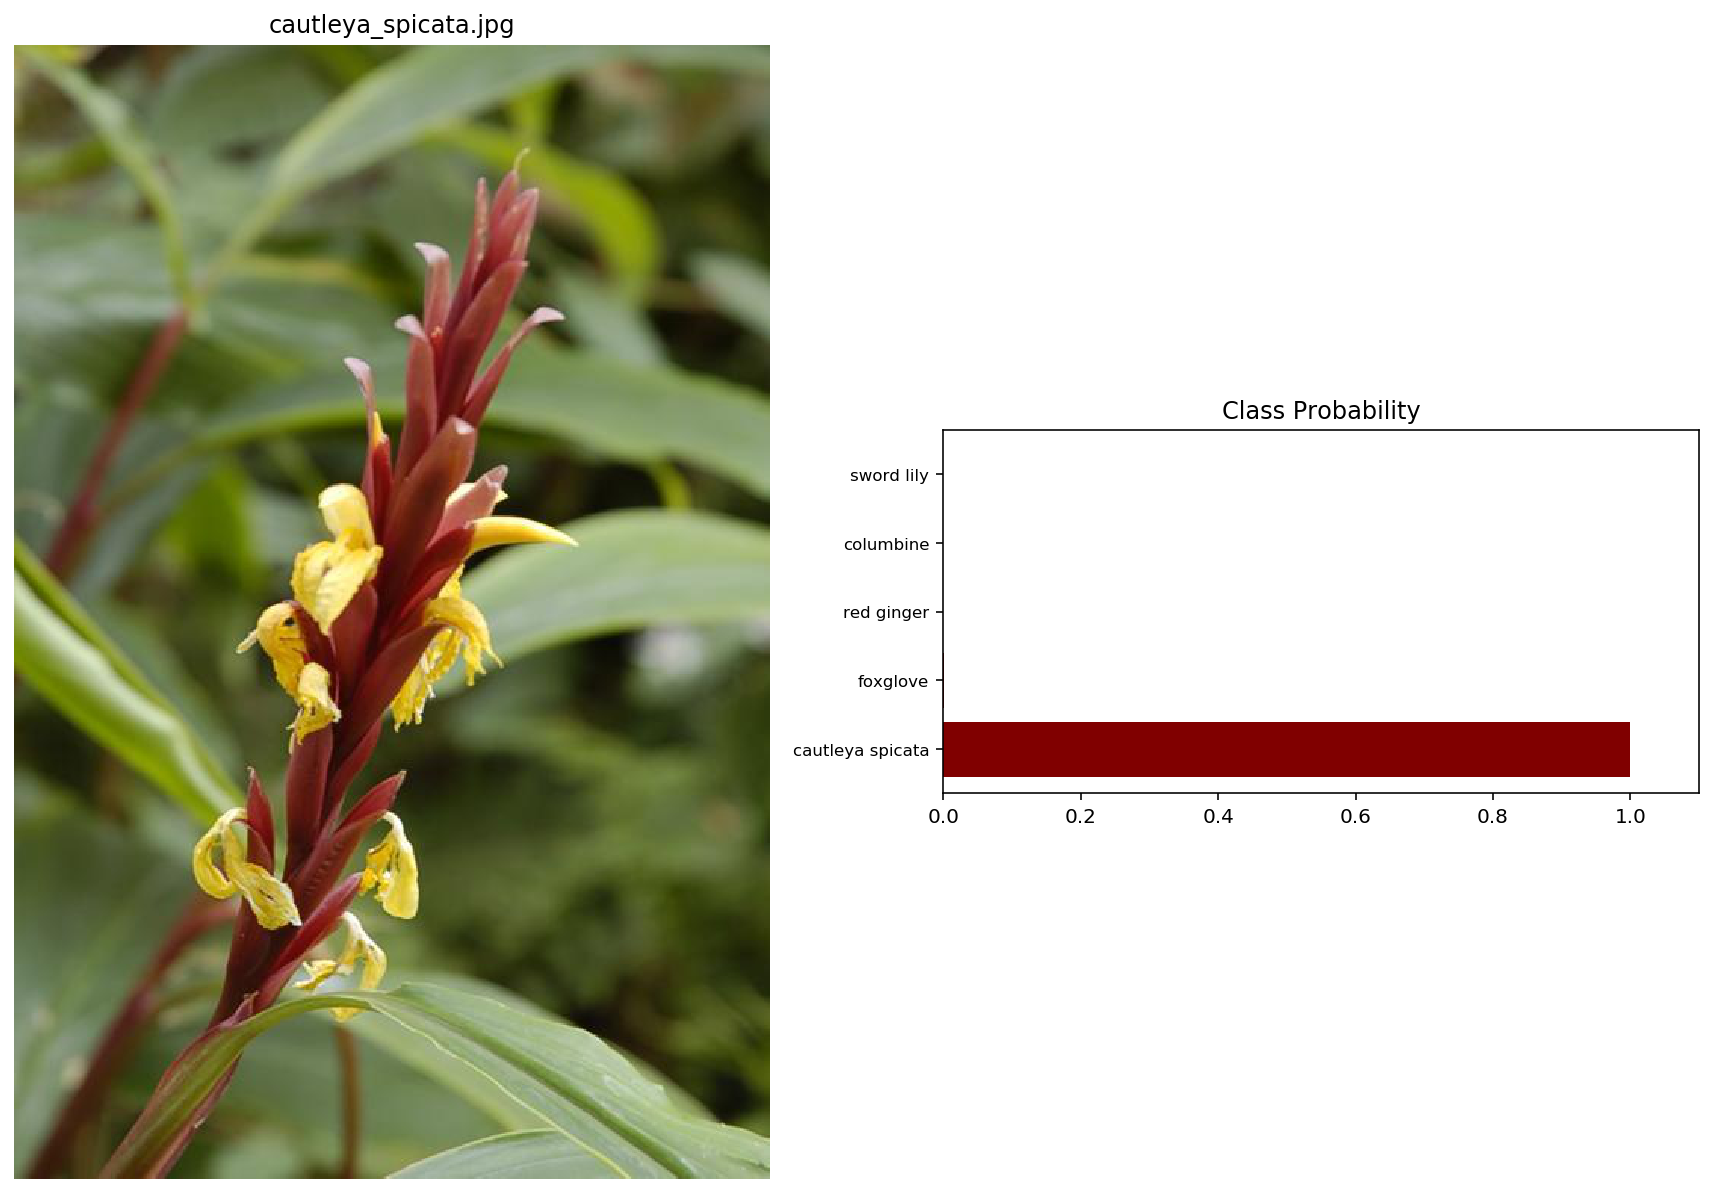

In [37]:
# TODO: Plot the input image along with the top 5 classes
import os 
path = './test_images/'
imgs = os.listdir(path)
imgs = [os.path.join(path,image) for image in imgs]
print(imgs)
for image_path in imgs:
    top_5_classes, probabilities = predict(image_path, loaded_model, 5)
    #probabilities = np.argpartition(probabilities, -4)[-4:]
    np_classes = np.array(class_names)
    print(probabilities, top_5_classes)
    im = Image.open(image_path)
    test_image = np.asarray(im)
    probabilities = probabilities / np.sum(probabilities)

    fig, ax1 = plt.subplots(figsize=(12,9), ncols=2, nrows=1)
    ax1[0].imshow(test_image)
    ax1[0].axis('off')
    ax1[0].set_title(image_path.split('/')[2])
    ax1[1].barh(np.arange(5), probabilities,color='maroon')
    ax1[1].set_aspect(0.1)
    ax1[1].set_yticks(np.arange(5))
    ax1[1].set_yticklabels(np_classes[top_5_classes], size='small');
    ax1[1].set_title('Class Probability')
    ax1[1].set_xlim(0, 1.1)
    plt.tight_layout()
    plt.show()



